In [383]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns

In [384]:
df = pd.read_csv("cause_of_deaths.csv")

In [385]:
#Content
#In this Dataset, we have Historical Data of different cause of deaths for all ages around the World. The key features of this Dataset are: Meningitis, Alzheimer's Disease and Other Dementias, Parkinson's Disease, Nutritional Deficiencies, Malaria, Drowning, Interpersonal Violence, Maternal Disorders, HIV/AIDS, Drug Use Disorders, Tuberculosis, Cardiovascular Diseases, Lower Respiratory Infections, Neonatal Disorders, Alcohol Use Disorders, Self-harm, Exposure to Forces of Nature, Diarrheal Diseases, Environmental Heat and Cold Exposure, Neoplasms, Conflict and Terrorism, Diabetes Mellitus, Chronic Kidney Disease, Poisonings, Protein-Energy Malnutrition, Road Injuries, Chronic Respiratory Diseases, Cirrhosis and Other Chronic Liver Diseases, Digestive Diseases, Fire, Heat, and Hot Substances, Acute Hepatitis.


In [386]:
df.head() 

,Country/Territory,Code,Year,Meningitis,Alzheimer's Disease and Other Dementias,Parkinson's Disease,Nutritional Deficiencies,Malaria,Drowning,Interpersonal Violence,...,Diabetes Mellitus,Chronic Kidney Disease,Poisonings,Protein-Energy Malnutrition,Road Injuries,Chronic Respiratory Diseases,Cirrhosis and Other Chronic Liver Diseases,Digestive Diseases,"Fire, Heat, and Hot Substances",Acute Hepatitis
0,Afghanistan,AFG,1990,2159,1116,371,2087,93,1370,1538,...,2108,3709,338,2054,4154,5945,2673,5005,323,2985
1,Afghanistan,AFG,1991,2218,1136,374,2153,189,1391,2001,...,2120,3724,351,2119,4472,6050,2728,5120,332,3092
2,Afghanistan,AFG,1992,2475,1162,378,2441,239,1514,2299,...,2153,3776,386,2404,5106,6223,2830,5335,360,3325
3,Afghanistan,AFG,1993,2812,1187,384,2837,108,1687,2589,...,2195,3862,425,2797,5681,6445,2943,5568,396,3601
4,Afghanistan,AFG,1994,3027,1211,391,3081,211,1809,2849,...,2231,3932,451,3038,6001,6664,3027,5739,420,3816


In [387]:
#Checking the data types before analysis
df.dtypes

Country/Territory                             object
Code                                          object
Year                                           int64
Meningitis                                     int64
Alzheimer's Disease and Other Dementias        int64
Parkinson's Disease                            int64
Nutritional Deficiencies                       int64
Malaria                                        int64
Drowning                                       int64
Interpersonal Violence                         int64
Maternal Disorders                             int64
HIV/AIDS                                       int64
Drug Use Disorders                             int64
Tuberculosis                                   int64
Cardiovascular Diseases                        int64
Lower Respiratory Infections                   int64
Neonatal Disorders                             int64
Alcohol Use Disorders                          int64
Self-harm                                     

In [388]:
#Reshape to long format for easier SQL queries and avoiding hard coding every column

In [389]:
#Keeping the coulmns that are used for identifies
id_vars = ["Country/Territory", "Year"]
#Columns to rows
value_vars = [col for col in df.columns if col not in id_vars and col != "Code"]
#melts to form the required long table
long_df = df.melt(
    id_vars=id_vars,
    value_vars=value_vars,
    var_name="Cause",
    value_name="DALYS"
)

In [390]:
#Checking if the reshaping was successful 
long_df.head()

,Country/Territory,Year,Cause,DALYS
0,Afghanistan,1990,Meningitis,2159
1,Afghanistan,1991,Meningitis,2218
2,Afghanistan,1992,Meningitis,2475
3,Afghanistan,1993,Meningitis,2812
4,Afghanistan,1994,Meningitis,3027


In [391]:
#connect to a SQLite database
conn = sqlite3.connect("Cause_deaths.db")

In [392]:
long_df.to_sql(
    name="deaths",
    con=conn,
    if_exists="replace",
    index=False
)

189720

In [393]:
# Q1 What are the leading causes of disease burden globally in the most recent year?

In [394]:
#SQL quiery for the top 10 Causes of the highest total DALYs in 2019
recent_trend = """
WITH d AS (
SELECT 
    Year, Cause, SUM(DALYS) AS total_dalys
    FROM deaths
    WHERE Year = 2019
    GROUP BY Cause)
SELECT Year, Cause, total_dalys
    FROM d
    ORDER BY total_dalys DESC
    LIMIT 10;

"""
recent_cause_df = pd.read_sql(recent_trend, conn)

In [395]:
recent_cause_df

,Year,Cause,total_dalys
0,2019,Cardiovascular Diseases,18552218
1,2019,Neoplasms,10074275
2,2019,Chronic Respiratory Diseases,3972681
3,2019,Digestive Diseases,2556209
4,2019,Lower Respiratory Infections,2491472
5,2019,Neonatal Disorders,1881372
6,2019,Alzheimer's Disease and Other Dementias,1622426
7,2019,Diabetes Mellitus,1549593
8,2019,Diarrheal Diseases,1533777
9,2019,Cirrhosis and Other Chronic Liver Diseases,1471148


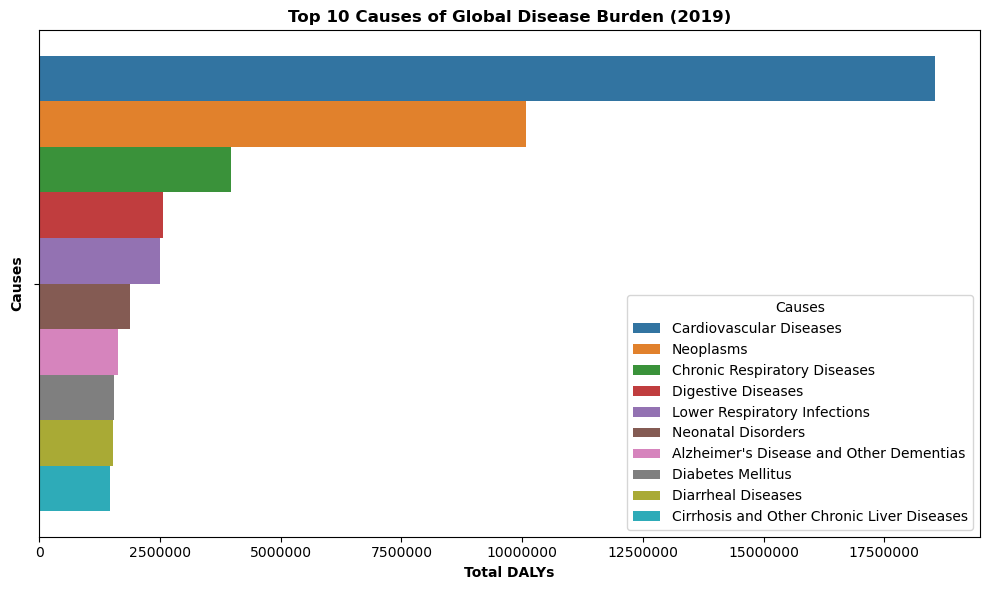

In [396]:
#Ploting the top 10 causes of diseases burdens 
plt.figure(figsize=(10, 6))

g = sns.barplot(
    data=recent_cause_df,
    x="total_dalys",
    hue="Cause",
    palette="tab10",
    width=0.9
)
plt.ticklabel_format(style='plain', axis='x')
plt.title("Top 10 Causes of Global Disease Burden (2019)", fontweight='bold')
plt.xlabel("Total DALYs", fontweight='bold')
plt.ylabel("Causes", fontweight='bold')
plt.legend(title = "Causes")
plt.tight_layout()
plt.show()

In [397]:
#The graph shows that cardiovascular diseases are by far the leading cause of global disease burden in 2019, contributing significantly more DALYs than any other condition. Non-communicable diseases such as neoplasms, chronic respiratory diseases, and diabetes dominate the top causes, while infectious and neonatal conditions account for a comparatively smaller share. This suggests a global shift towards long-term, lifestyle- and age-related conditions as major drivers of ill health. Given this apparent dominance of non-communicable diseases, it is important to understand how these patterns have evolved over time, leading to the next question.

In [398]:
# Q2 How has the global burden of disease changed since 1990?

In [399]:
#SQL quiery by year for the the total DALYs
change_trend = """
SELECT year, SUM(DALYS) AS total_dalys
    FROM deaths
    GROUP BY year
    ORDER BY year;
"""
change_cause_df = pd.read_sql(change_trend, conn)

In [400]:
change_cause_df

,Year,total_dalys
0,1990,43518516
1,1991,44059729
2,1992,44459130
3,1993,45185713
4,1994,46182613
5,1995,46177018
6,1996,46320827
7,1997,46672370
8,1998,47066088
9,1999,47652090


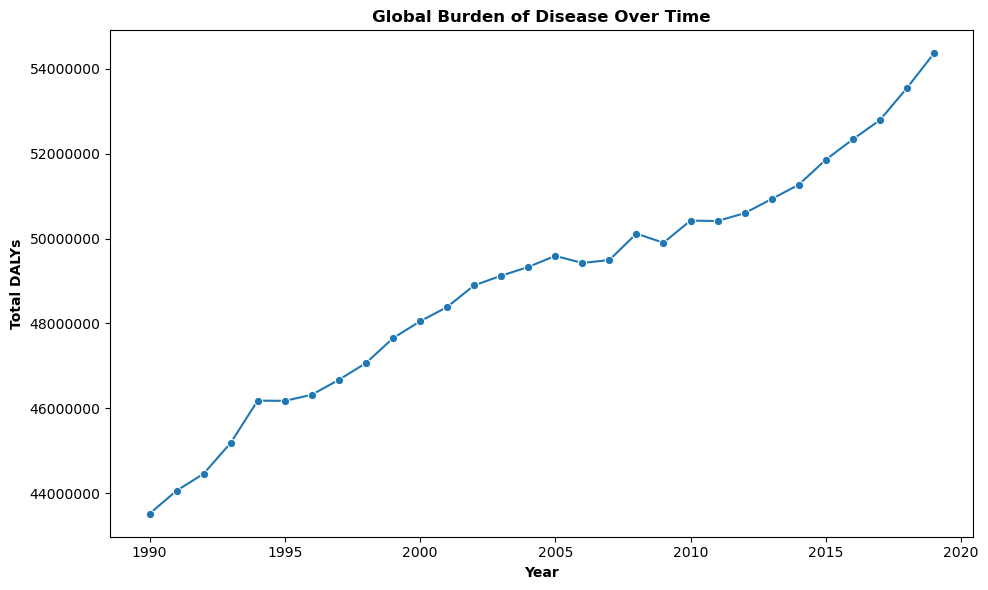

In [401]:
#Plot line graph to see changes
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=change_cause_df,
    x="Year",
    y="total_dalys",
    marker="o"
)
plt.title("Global Burden of Disease Over Time", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Total DALYs", fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

In [402]:
#The graph shows a clear upward trend in the global burden of disease from 1990 to 2019, with total DALYs increasing steadily over time despite minor fluctuations in the mid-2000s. This indicates that, overall, the global health burden has grown rather than declined, likely influenced by population growth, ageing populations, and the rising prevalence of chronic conditions. Given this sustained increase in total disease burden, it is important to examine which specific conditions are driving this trend, leading to the next question

In [403]:
# Q3 How has the burden of cardiovascular diseases changed over time?

In [404]:
#SQL quiery for cardiovascular diseases per year
cd_trend = """
SELECT
    year, cause, SUM(dalys) AS total_dalys
FROM deaths
WHERE cause = "Cardiovascular Diseases"
GROUP BY year, cause;
"""
cd_trend_df = pd.read_sql(cd_trend, conn)

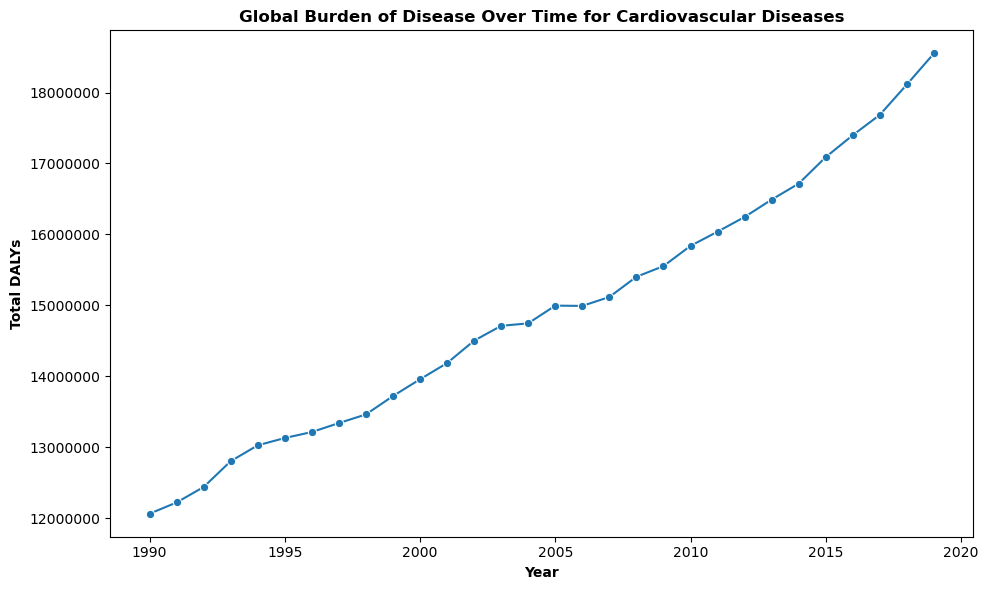

In [405]:
#Plot line graph to see changes
plt.figure(figsize=(10, 6))
ax = sns.lineplot(
    data=cd_trend_df,
    x="Year",
    y="total_dalys",
    marker="o"
)
plt.title("Global Burden of Disease Over Time for Cardiovascular Diseases", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Total DALYs", fontweight='bold')
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

In [406]:
#The graph shows a sustained increase in the global burden of cardiovascular diseases from 1990 to 2019, with total DALYs rising steadily over time and accelerating in the later years. While part of this increase may be attributable to population growth and ageing, the consistent upward trend suggests that cardiovascular conditions have become an increasingly significant contributor to overall global disease burden. Given the growing impact of cardiovascular disease, the leading non-communicable condition, this raises a broader question about changing disease patterns, leading to Q4

In [407]:
# Q4 Is there a shift from communicable to non-communicable diseases over time?

In [408]:
#SQL quiery for the total DALYS per Cause per year
com_to_non_trend = """
SELECT
    year, cause, SUM(dalys) AS total_dalys
FROM deaths
GROUP BY year, cause;
"""
change_tocom_cause_df = pd.read_sql(com_to_non_trend, conn)

In [409]:
change_tocom_cause_df

,Year,Cause,total_dalys
0,1990,Acute Hepatitis,166343
1,1990,Alcohol Use Disorders,116390
2,1990,Alzheimer's Disease and Other Dementias,560616
3,1990,Cardiovascular Diseases,12062179
4,1990,Chronic Kidney Disease,600925
...,...,...,...
925,2019,Poisonings,77130
926,2019,Protein-Energy Malnutrition,212080
927,2019,Road Injuries,1197575
928,2019,Self-harm,758697


In [410]:
#Classifying the causes to 3 different categories : Communicable , Non-communicable and Injuries
cause_category = {
    # Communicable
    "HIV/AIDS": "Communicable",
    "Tuberculosis": "Communicable",
    "Malaria": "Communicable",
    "Diarrheal Diseases": "Communicable",
    "Lower Respiratory Infections": "Communicable",
    "Neonatal Disorders": "Communicable",
    "Acute Hepatitis": "Communicable",
    "Meningitis": "Communicable",

    # Non-communicable
    "Cardiovascular Diseases": "Non-communicable",
    "Neoplasms": "Non-communicable",
    "Diabetes Mellitus": "Non-communicable",
    "Chronic Respiratory Diseases": "Non-communicable",
    "Chronic Kidney Disease": "Non-communicable",
    "Cirrhosis and Other Chronic Liver Diseases": "Non-communicable",
    "Alzheimer's Disease and Other Dementias": "Non-communicable",
    "Digestive Diseases": "Non-communicable",

    # Injuries
    "Road Injuries": "Injuries",
    "Interpersonal Violence": "Injuries",
    "Self-harm": "Injuries",
    "Conflict and Terrorism": "Injuries",
    "Drowning": "Injuries",
    "Fire, Heat, and Hot Substances": "Injuries",
    "Exposure to Forces of Nature": "Injuries"
}
change_tocom_cause_df["Category"] = change_tocom_cause_df["Cause"].map(cause_category)
change_tocom_cause_df["Category"] = (change_tocom_cause_df["Cause"].map(cause_category).fillna("Non-communicable"))

new_category_trend = change_tocom_cause_df.groupby(["Year", "Category"])["total_dalys"].sum().reset_index()


new_category_df = new_category_trend.pivot(
    index = "Year",
    columns= "Category",
    values="total_dalys"
)

new_category_df

Category,Communicable,Injuries,Non-communicable
Year,,,
1990,12769481,2974156,27774879
1991,12831108,3073173,28155448
1992,12875329,2949172,28634629
1993,12834197,3019235,29332281
1994,12806962,3565055,29810596
1995,12802470,3085172,30289376
1996,12773212,3067900,30479715
1997,12790157,3076557,30805656
1998,12810103,3128580,31127405


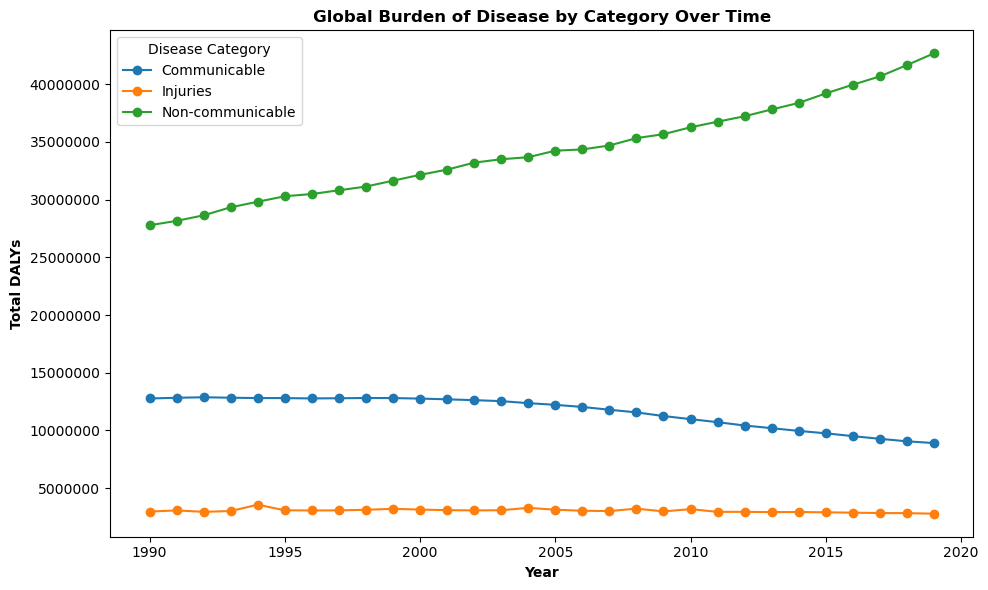

In [411]:
#Plotting line graph to compare visually
plt.figure(figsize=(10, 6))

for category in new_category_df.columns:
    plt.plot(
        new_category_df.index,
        new_category_df[category],
        marker="o",
        label=category
    )

plt.title("Global Burden of Disease by Category Over Time", fontweight='bold')
plt.xlabel("Year", fontweight='bold')
plt.ylabel("Total DALYs", fontweight='bold')
plt.legend(title="Disease Category")
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()
                

In [412]:
#The graph shows that non-communicable diseases have been the leading contributor to the global disease burden throughout the entire period from 1990 to 2019. However, their share of total DALYs has increased steadily over time, while the burden from communicable diseases has declined and injuries have remained relatively stable. This indicates not a sudden transition, but a gradual intensification of an existing dominance of non-communicable diseases at the global level. Given this global pattern, it is important to examine whether the relative contribution of disease categories differs by country, leading to Q5

In [413]:
# Q5 How does the composition of disease burden differ between the UK and the global average?

In [414]:
#SQL quiery for the year, Country and cause and total_dalys
world_trend = """
SELECT
    year, "Country/Territory", cause, SUM(dalys) AS total_dalys
FROM deaths
GROUP BY year, "Country/Territory", cause;
""";

a_cause_df = pd.read_sql(world_trend, conn)

a_cause_df["Category"] = a_cause_df["Cause"].map(cause_category)
a_cause_df["Category"] = (a_cause_df["Cause"].map(cause_category).fillna("Non-communicable"))
#Only including the UK and 2019
uk_trend = a_cause_df[(a_cause_df["Year"] == 2019) & (a_cause_df["Country/Territory"] == "United Kingdom")].groupby("Category")["total_dalys"].sum().reset_index()
#percentage of DALYs of the UK 
uk_trend["Percentage"] = (uk_trend["total_dalys"] / uk_trend["total_dalys"].sum() * 100).round(2)
#percentage of dalys of the World
worldvsuk_trend = a_cause_df[a_cause_df["Year"] == 2019].groupby("Category")["total_dalys"].sum().reset_index()
worldvsuk_trend["Percentage"] = (worldvsuk_trend["total_dalys"] / worldvsuk_trend["total_dalys"].sum() * 100).round(2)

In [415]:
#Adding a new column that will be used as an identifier
uk_trend["Region"] = "United Kingdom"
uk_trend

,Category,total_dalys,Percentage,Region
0,Communicable,45690,7.70,United Kingdom
1,Injuries,9338,1.57,United Kingdom
2,Non-communicable,538708,90.73,United Kingdom


In [416]:
worldvsuk_trend["Region"] = "Global"
worldvsuk_trend

,Category,total_dalys,Percentage,Region
0,Communicable,8907338,16.38,Global
1,Injuries,2787701,5.13,Global
2,Non-communicable,42667881,78.49,Global


In [417]:
#Combining to one dataset
comparison_df = pd.concat([uk_trend, worldvsuk_trend]) 
comparison_df

,Category,total_dalys,Percentage,Region
0,Communicable,45690,7.70,United Kingdom
1,Injuries,9338,1.57,United Kingdom
2,Non-communicable,538708,90.73,United Kingdom
0,Communicable,8907338,16.38,Global
1,Injuries,2787701,5.13,Global
2,Non-communicable,42667881,78.49,Global


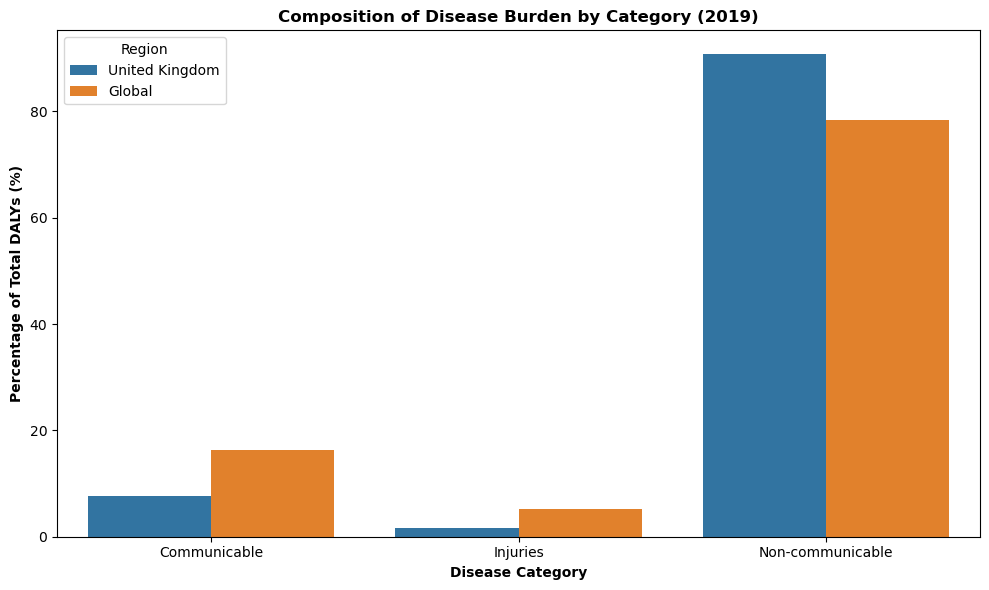

In [418]:
# plotting a barplot to compare the UK and World trends per Category
plt.figure(figsize=(10, 6))

sns.barplot(
    data=comparison_df,
    x="Category",
    y="Percentage",
    hue="Region")

plt.title("Composition of Disease Burden by Category (2019)", fontweight='bold')
plt.xlabel("Disease Category", fontweight='bold')
plt.ylabel("Percentage of Total DALYs (%)", fontweight='bold')
plt.legend(title="Region")
#plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

In [419]:
#The graph shows that in 2019 the disease burden in the United Kingdom is overwhelmingly dominated by non-communicable diseases, which account for a substantially higher proportion of total DALYs compared to the global average. In contrast, communicable diseases and injuries make up a much smaller share of the disease burden in the UK, while these categories contribute more significantly at the global level. This highlights how disease burden composition varies by level of development, healthcare access, and demographic structure. To explore whether these patterns are consistent across different national contexts, this leads to Q6

In [420]:
# Q6 How does the composition of disease burden differ across selected countries?

In [421]:
#SQL quiery for the Country, cause and total_dalys, selecting 6 countries for comaparison
selected_trend = """
SELECT
    "Country/Territory", cause, SUM(dalys) AS total_dalys
FROM deaths
WHERE year = '2019' AND "Country/Territory" IN ("United Kingdom", "United States", "India", "Nigeria", "Brazil", "China")
GROUP BY "Country/Territory", cause;
"""
selected_trend_df = pd.read_sql(selected_trend, conn)

In [422]:
#Mapping the cause_category dictionary again
selected_trend_df["Category"] = selected_trend_df["Cause"].map(cause_category)
selected_trend_df["Category"] = (selected_trend_df["Cause"].map(cause_category).fillna("Non-communicable"))

In [423]:
#Grouping by country and category
selected_df = selected_trend_df.groupby(["Country/Territory", "Category"])["total_dalys"].sum().reset_index()

In [424]:
#Adding a new column of the precentage change using the sum of the totol_DALYs per country as the total
selected_df["Percentage"] = (selected_df["total_dalys"] / selected_df.groupby("Country/Territory")["total_dalys"].transform("sum") * 100).round(2)

In [425]:
selected_df

,Country/Territory,Category,total_dalys,Percentage
0,Brazil,Communicable,149225,11.15
1,Brazil,Injuries,131732,9.84
2,Brazil,Non-communicable,1057833,79.01
3,China,Communicable,314157,3.01
4,China,Injuries,451127,4.32
5,China,Non-communicable,9677277,92.67
6,India,Communicable,2072037,23.51
7,India,Injuries,530940,6.02
8,India,Non-communicable,6209770,70.46
9,Nigeria,Communicable,915621,63.61


In [426]:
#Pivoting for better plotting of percentages 
selected_heat_df = selected_df.pivot(
    index = "Country/Territory",
    columns = "Category",
    values = "Percentage"
)

In [427]:
selected_heat_df

Category,Communicable,Injuries,Non-communicable
Country/Territory,,,
Brazil,11.15,9.84,79.01
China,3.01,4.32,92.67
India,23.51,6.02,70.46
Nigeria,63.61,3.45,32.94
United Kingdom,7.70,1.57,90.73
United States,4.02,3.94,92.04


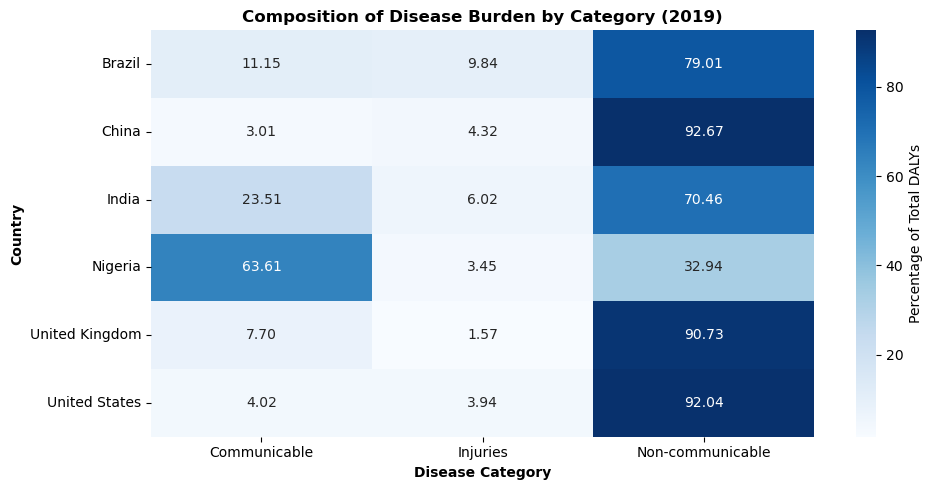

In [428]:
#Heatmap 
plt.figure(figsize=(10, 5))
sns.heatmap(
    selected_heat_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={"label": "Percentage of Total DALYs"}
)
plt.title("Composition of Disease Burden by Category (2019)", fontweight='bold')
plt.xlabel("Disease Category", fontweight='bold')
plt.ylabel("Country", fontweight='bold')

plt.tight_layout()
plt.show()

In [429]:
#The graph highlights substantial differences in the composition of disease burden across selected countries in 2019. High-income countries such as the United Kingdom and the United States have disease burdens overwhelmingly dominated by non-communicable diseases, with very low contributions from communicable diseases and injuries. Middle-income countries like China and Brazil also show a strong predominance of non-communicable diseases, though with slightly higher shares of communicable conditions. In contrast, Nigeria displays a markedly different profile, with communicable diseases accounting for the majority of its total disease burden, while non-communicable diseases represent a much smaller share.These contrasting patterns suggest a strong relationship between a country’s level of economic development and the dominant categories of disease burden, leading to Q7.

In [430]:
# Q7 Does country income group affect the burdern of disease category?

In [431]:
# World Bank list of economies (June 2019)
country_income_group = {
    "Afghanistan": "Low income",
    "Albania": "Upper middle income",
    "Algeria": "Upper middle income",
    "American Samoa": "Upper middle income",
    "Andorra": "High income",
    "Angola": "Lower middle income",
    "Antigua and Barbuda": "High income",
    "Argentina": "Upper middle income",
    "Armenia": "Upper middle income",
    "Aruba": "High income",
    "Australia": "High income",
    "Austria": "High income",
    "Azerbaijan": "Upper middle income",
    "Bahamas": "High income",
    "Bahrain": "High income",
    "Bangladesh": "Lower middle income",
    "Barbados": "High income",
    "Belarus": "Upper middle income",
    "Belgium": "High income",
    "Belize": "Upper middle income",
    "Benin": "Low income",
    "Bermuda": "High income",
    "Bhutan": "Lower middle income",
    "Bolivia": "Lower middle income",
    "Bosnia and Herzegovina": "Upper middle income",
    "Botswana": "Upper middle income",
    "Brazil": "Upper middle income",
    "British Virgin Islands": "High income",
    "Brunei": "High income",
    "Bulgaria": "Upper middle income",
    "Burkina Faso": "Low income",
    "Burundi": "Low income",
    "Cape Verde": "Lower middle income",
    "Cambodia": "Lower middle income",
    "Cameroon": "Lower middle income",
    "Canada": "High income",
    "Cayman Islands": "High income",
    "Central African Republic": "Low income",
    "Chad": "Low income",
    "Channel Islands": "High income",
    "Chile": "High income",
    "China": "Upper middle income",
    "Colombia": "Upper middle income",
    "Cook Islands": "Upper middle income",
    "Comoros": "Lower middle income",
    "Democratic Republic of Congo": "Low income",
    "Congo": "Lower middle income",
    "Costa Rica": "Upper middle income",
    "Cote d'Ivoire": "Lower middle income",
    "Croatia": "High income",
    "Cuba": "Upper middle income",
    "Curaçao": "High income",
    "Cyprus": "High income",
    "Czechia": "High income",
    "Denmark": "High income",
    "Djibouti": "Lower middle income",
    "Dominica": "Upper middle income",
    "Dominican Republic": "Upper middle income",
    "Ecuador": "Upper middle income",
    "Egypt": "Lower middle income",
    "El Salvador": "Lower middle income",
    "Equatorial Guinea": "Upper middle income",
    "Eritrea": "Low income",
    "Estonia": "High income",
    "Eswatini": "Lower middle income",
    "Ethiopia": "Low income",
    "Faroe Islands": "High income",
    "Fiji": "Upper middle income",
    "Finland": "High income",
    "France": "High income",
    "French Polynesia": "High income",
    "Gabon": "Upper middle income",
    "Gambia": "Low income",
    "Georgia": "Upper middle income",
    "Germany": "High income",
    "Ghana": "Lower middle income",
    "Gibraltar": "High income",
    "Greece": "High income",
    "Greenland": "High income",
    "Grenada": "Upper middle income",
    "Guam": "High income",
    "Guatemala": "Upper middle income",
    "Guinea": "Low income",
    "Guinea-Bissau": "Low income",
    "Guyana": "Upper middle income",
    "Haiti": "Low income",
    "Honduras": "Lower middle income",
    "Hong Kong SAR, China": "High income",
    "Hungary": "High income",
    "Iceland": "High income",
    "India": "Lower middle income",
    "Indonesia": "Lower middle income",
    "Iran": "Upper middle income",
    "Iraq": "Upper middle income",
    "Ireland": "High income",
    "Isle of Man": "High income",
    "Israel": "High income",
    "Italy": "High income",
    "Jamaica": "Upper middle income",
    "Japan": "High income",
    "Jordan": "Upper middle income",
    "Kazakhstan": "Upper middle income",
    "Kenya": "Lower middle income",
    "Kiribati": "Lower middle income",
    "North Korea": "Low income",
    "South Korea": "High income",
    "Kosovo": "Upper middle income",
    "Kuwait": "High income",
    "Kyrgyzstan": "Lower middle income",
    "Laos": "Lower middle income",
    "Latvia": "High income",
    "Lebanon": "Upper middle income",
    "Lesotho": "Lower middle income",
    "Liberia": "Low income",
    "Libya": "Upper middle income",
    "Liechtenstein": "High income",
    "Lithuania": "High income",
    "Luxembourg": "High income",
    "Macao SAR, China": "High income",
    "Madagascar": "Low income",
    "Malawi": "Low income",
    "Malaysia": "Upper middle income",
    "Maldives": "Upper middle income",
    "Mali": "Low income",
    "Malta": "High income",
    "Marshall Islands": "Upper middle income",
    "Mauritania": "Lower middle income",
    "Mauritius": "Upper middle income",
    "Mexico": "Upper middle income",
    "Micronesia": "Lower middle income",
    "Moldova": "Lower middle income",
    "Monaco": "High income",
    "Mongolia": "Lower middle income",
    "Montenegro": "Upper middle income",
    "Morocco": "Lower middle income",
    "Mozambique": "Low income",
    "Myanmar": "Lower middle income",
    "Namibia": "Upper middle income",
    "Nauru": "Upper middle income",
    "Niue": "High income",
    "Nepal": "Low income",
    "Netherlands": "High income",
    "New Caledonia": "High income",
    "New Zealand": "High income",
    "Nicaragua": "Lower middle income",
    "Niger": "Low income",
    "Nigeria": "Lower middle income",
    "North Macedonia": "Upper middle income",
    "Northern Mariana Islands": "High income",
    "Norway": "High income",
    "Oman": "High income",
    "Pakistan": "Lower middle income",
    "Palau": "High income",
    "Panama": "High income",
    "Papua New Guinea": "Lower middle income",
    "Paraguay": "Upper middle income",
    "Peru": "Upper middle income",
    "Palestine": "Upper middle income",
    "Philippines": "Lower middle income",
    "Poland": "High income",
    "Portugal": "High income",
    "Puerto Rico": "High income",
    "Qatar": "High income",
    "Romania": "Upper middle income",
    "Russia": "Upper middle income",
    "Rwanda": "Low income",
    "Samoa": "Upper middle income",
    "San Marino": "High income",
    "Sao Tome and Principe": "Lower middle income",
    "Saudi Arabia": "High income",
    "Senegal": "Lower middle income",
    "Serbia": "Upper middle income",
    "Seychelles": "High income",
    "Sierra Leone": "Low income",
    "Singapore": "High income",
    "Sint Maarten (Dutch part)": "High income",
    "Slovakia": "High income",
    "Slovenia": "High income",
    "Solomon Islands": "Lower middle income",
    "Somalia": "Low income",
    "South Africa": "Upper middle income",
    "South Sudan": "Low income",
    "Spain": "High income",
    "Sri Lanka": "Upper middle income",
    "Saint Kitts and Nevis": "High income",
    "Saint Lucia": "Upper middle income",
    "St. Martin (French part)": "High income",
    "Saint Vincent and the Grenadines": "Upper middle income",
    "Sudan": "Lower middle income",
    "Suriname": "Upper middle income",
    "Sweden": "High income",
    "Switzerland": "High income",
    "Syria": "Low income",
    "Taiwan": "High income",
    "Tajikistan": "Low income",
    "Tanzania": "Low income",
    "Thailand": "Upper middle income",
    "Timor": "Lower middle income",
    "Togo": "Low income",
    "Tonga": "Upper middle income",
    "Tokelau": "Lower middle income",
    "Trinidad and Tobago": "High income",
    "Tunisia": "Lower middle income",
    "Turkey": "Upper middle income",
    "Turkmenistan": "Upper middle income",
    "Turks and Caicos Islands": "High income",
    "Tuvalu": "Upper middle income",
    "Uganda": "Low income",
    "Ukraine": "Lower middle income",
    "United Arab Emirates": "High income",
    "United Kingdom": "High income",
    "United States": "High income",
    "Uruguay": "High income",
    "Uzbekistan": "Lower middle income",
    "Vanuatu": "Lower middle income",
    "Venezuela": "Upper middle income",
    "Vietnam": "Lower middle income",
    "United States Virgin Islands": "High income",
    "West Bank and Gaza": "Lower middle income",
    "Yemen": "Low income",
    "Zambia": "Lower middle income",
    "Zimbabwe": "Lower middle income"
}
income_trend = """
SELECT
    "Country/Territory", cause, SUM(dalys) AS total_dalys
FROM deaths
WHERE year = '2019'
GROUP BY "Country/Territory", cause;
"""
income_trend_df = pd.read_sql(income_trend, conn)

In [432]:
#Mapping the country_income_group dictionary
income_trend_df["Income group"] = income_trend_df["Country/Territory"].map(country_income_group)
income_trend_df["Income group"] = (income_trend_df["Country/Territory"].map(country_income_group).fillna("N/A"))
income_trend_df["Category"] = income_trend_df["Cause"].map(cause_category)
income_trend_df["Category"] = (income_trend_df["Cause"].map(cause_category).fillna("Non-communicable"))

In [433]:
#Checking if there were any countries that were not assigned to any income groups
income_trend_df[income_trend_df["Income group"] == "N/A"] 

,Country/Territory,Cause,total_dalys,Income group,Category


In [434]:
#calulating the percentage of Total DALYs per income group
income_df = income_trend_df.groupby(["Income group", "Category"])["total_dalys"].sum().reset_index()
income_df["Percentage"] = (income_df["total_dalys"] / income_df.groupby("Income group")["total_dalys"].transform("sum") * 100).round(2)

In [435]:
#Pivoting table
income_heat_df = income_df.pivot(
    index = "Income group",
    columns = "Category",
    values = "Percentage"
)

In [436]:
#Reordering to order from lowest to highest income groups 
income_order = [
    "Low income",
    "Lower middle income",
    "Upper middle income",
    "High income"]
income_heat_df = income_heat_df.reindex(income_order)

income_heat_df


Category,Communicable,Injuries,Non-communicable
Income group,,,
Low income,44.86,6.68,48.47
Lower middle income,25.63,5.24,69.13
Upper middle income,6.20,5.58,88.23
High income,5.10,3.40,91.50


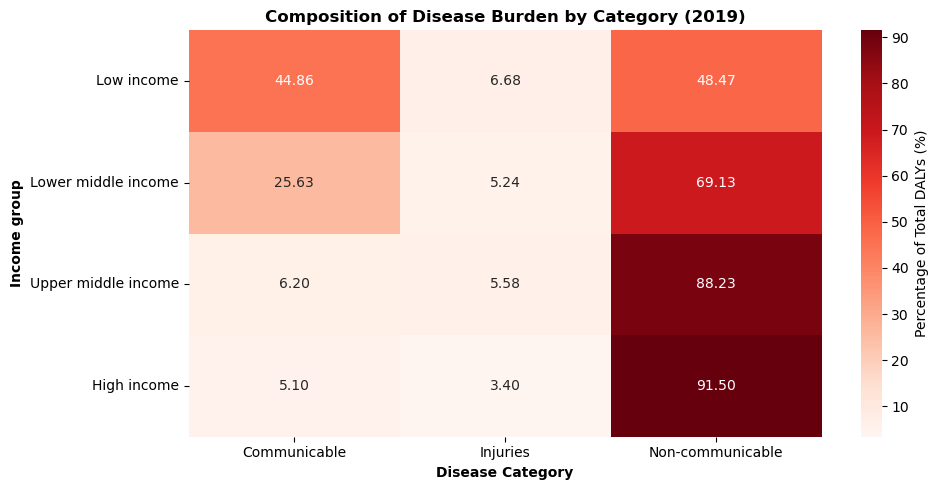

In [437]:
#Producing a heatmap of the table above
plt.figure(figsize=(10, 5))
sns.heatmap(
    income_heat_df,
    annot=True,
    fmt=".2f",
    cmap="Reds",
    cbar_kws={"label": "Percentage of Total DALYs (%)"}
)
plt.title("Composition of Disease Burden by Category (2019)", fontweight='bold')
plt.xlabel("Disease Category", fontweight='bold')
plt.ylabel("Income group", fontweight='bold')

plt.tight_layout()
plt.show()

In [438]:
#The graph shows a strong relationship between country income group and the composition of disease burden in 2019. Low-income countries experience a nearly equal burden from communicable and non-communicable diseases, while lower-middle-income countries already show a clear shift towards non-communicable conditions. This pattern becomes more pronounced in upper-middle- and high-income countries, where non-communicable diseases account for the vast majority of total DALYs and communicable diseases contribute only a small share. Injuries remain relatively stable across income groups but consistently represent a minor proportion of the overall burden. These findings suggest that economic development is closely associated with changes in disease burden composition, reflecting improvements in infectious disease control alongside rising chronic disease prevalence.

In [439]:
# Q8 Which causes have seen the largest increase or decrease since 1990?

In [440]:
#SQL query 
large_small_trend = """
SELECT
    cause, year, SUM(dalys) AS total_dalys
FROM deaths
GROUP BY cause, year;
"""
large_small_trend_df = pd.read_sql(large_small_trend, conn)

In [441]:
large_small_trend_df

,Cause,Year,total_dalys
0,Acute Hepatitis,1990,166343
1,Acute Hepatitis,1991,165276
2,Acute Hepatitis,1992,163687
3,Acute Hepatitis,1993,161899
4,Acute Hepatitis,1994,159423
...,...,...,...
925,Tuberculosis,2015,1267556
926,Tuberculosis,2016,1249524
927,Tuberculosis,2017,1231689
928,Tuberculosis,2018,1204916


In [442]:
#Pivoting table
large_small_df = large_small_trend_df.pivot(
    index = "Cause",
    columns = "Year",
    values = "total_dalys")

In [443]:
#Calculating changes from 2019 to 1990
large_small_df["change since 1990"] = large_small_df[2019] - large_small_df[1990]

In [444]:
#assigning the largest increases and decreases by reordering values
largest_increase = large_small_df.sort_values("change since 1990", ascending=False)
largest_decrease = large_small_df.sort_values("change since 1990")

In [445]:
#Top 5 Largest Decreases and Increases in DALYs Since 1990
largestvssmall_df = pd.concat([largest_increase.head(5),
largest_decrease.head(5)]).sort_values("change since 1990")

In [446]:
largestvssmall_df

Year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,change since 1990
Cause,,,,,,,,,,,,,,,,,,,,,
Diarrheal Diseases,2894957,2903085,2871809,2798615,2740299,2673263,2615313,2579027,2544585,2496957,...,1902762,1834769,1788081,1725693,1679043,1639826,1632183,1577953,1533777,-1361180
Neonatal Disorders,3004581,2975087,2950376,2924485,2896505,2873608,2841042,2817527,2793540,2766241,...,2383664,2339979,2299343,2237472,2183143,2099079,2014896,1942350,1881372,-1123209
Lower Respiratory Infections,3318264,3282941,3258792,3226972,3187285,3148775,3091233,3047670,2999755,2950639,...,2527899,2526051,2537037,2532104,2533068,2516135,2487918,2486438,2491472,-826792
Tuberculosis,1776727,1786389,1807740,1774711,1753811,1738759,1720903,1726038,1724307,1719130,...,1331697,1318198,1307485,1294816,1267556,1249524,1231689,1204916,1179234,-597493
Nutritional Deficiencies,756808,729145,700664,674219,649801,723095,671977,647682,620498,593417,...,314327,298117,291451,284578,278793,273191,267463,258094,251411,-505397
Chronic Respiratory Diseases,3092759,3148288,3207816,3266612,3297292,3313295,3342591,3381872,3401426,3419612,...,3539167,3558276,3610804,3651653,3690907,3740794,3795946,3886637,3972681,879922
Diabetes Mellitus,661085,679630,702253,728077,751254,773490,799023,827734,854415,879521,...,1197995,1236606,1277414,1320608,1366100,1412896,1454681,1501633,1549593,888508
Alzheimer's Disease and Other Dementias,560616,583166,605894,629571,652176,674815,696665,717342,738768,761620,...,1201138,1247515,1294701,1343756,1394942,1451840,1509646,1568617,1622426,1061810
Neoplasms,5752596,5867965,5996098,6167069,6296066,6402881,6490603,6586074,6703169,6857548,...,8468793,8611952,8757263,8920309,9133616,9336894,9529491,9791758,10074275,4321679


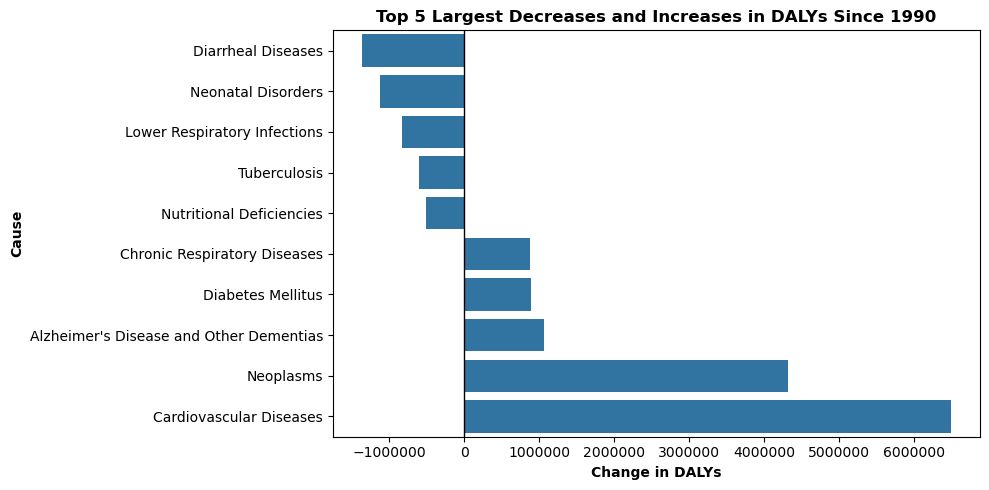

In [447]:
#Plotting the Top 5 Largest Decreases and Increases in DALYs Since 1990 on a bar plot
plt.figure(figsize=(10, 5))

sns.barplot(
    data=largestvssmall_df,
    x="change since 1990",
    y=largestvssmall_df.index,
    
)

plt.axvline(0, color="black", linewidth=1)

plt.title("Top 5 Largest Decreases and Increases in DALYs Since 1990", fontweight='bold')
plt.xlabel("Change in DALYs", fontweight='bold')
plt.ylabel("Cause", fontweight='bold')
plt.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

In [448]:
#The graph shows that the largest increases in global disease burden since 1990 have occurred in non-communicable diseases, particularly cardiovascular diseases and neoplasms, which have seen substantial rises in total DALYs. Other chronic conditions, including diabetes mellitus, chronic respiratory diseases, and Alzheimer’s disease and other dementias, have also increased, reflecting ageing populations and lifestyle-related risk factors.In contrast, the largest decreases in disease burden have been observed in communicable and preventable conditions such as diarrhoeal diseases, neonatal disorders, lower respiratory infections, tuberculosis, and nutritional deficiencies. These declines likely reflect improvements in public health measures, healthcare access, vaccination, sanitation, and maternal and child health interventions. Overall, this reinforces the broader trend identified throughout the analysis: while progress has been made in reducing communicable disease burden, non-communicable diseases have become the dominant and fastest-growing contributors to global health loss since 1990.